This script prepares the data for the evaluation of importance factor, but also analyze the metrics and variables involved in that analysis
In this script
0. Format all the variables together 
1. Plot the summary results 
1.1. For section 2.1 in the paper
1.2 For all the lakes
2. Plot relation RMSE/Lake Variability
3. Plot all the variables

In [ ]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingRegressor
import platform
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as plt
from datetime import datetime
import os
import itertools
import time
import statsmodels.api as sm
# from sklearn import linear_model

# import dtale
from icecream import ic
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
#Get all lakes 
if platform.system()=='Linux':
    base_path='/home/angelica/Documents/py_linux/'
else:
    base_path='C:/Users/amgomez/Documents/PythonScripts/'

In [ ]:
### Predictors I should pick
1. Length of the orbit crossing the lake: orbit_leng
2. Area of the lake influence by the orbit: area_buffe
3. Lake area: Lake_area
4. Topography roughness: TRI_mdn
5. Variability of Lake surface water elevation (Option 1): APL
6. Variability of Lake surface water elevation (Option 2 flashiness index Baker 2004): rb_index
7. Variance of observations?? roughness. Standard deviation of the differences, based on https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r. I have std_diff and mean_diff. To calculate the variability it should be std_diff/abs(mean_diff) if mean diff!=0
8. Standard deviation of the observations std_obs
9. Probablility of ICE ??
10. No Samples from altimeter data
##3 Reponse variables to try

In [ ]:
## 1. Length of the orbit crossing the lake 
## To get the total length
### - Get the lakes
### - Open sd file
### - Link lakes to sd file
### - Filter only the evaluation lakes
### - Group lakes by lake_id and orbit to sum the length (sum the projected and non projected length

In [ ]:
# Function to get Karina's station data 
def get_us_ca_data(df_results, gauge_id_fd, path_to_obs, folder_sep):
    list_gauges=df_results[gauge_id_fd].unique()
    #TODO validate empty list
    df_files=pd.DataFrame()
    for folder,details in folder_sep.items():
        path=path_to_obs+folder+'/'
        sep=details['sep']
        org_col_fd=details['fields'].values()
        new_col_fd={v: k for k, v in details['fields'].items()} 
        # print(sep, new_col_fd)
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))&(f.endswith('.dat'))&(f[:-4] in list_gauges)]
         
        for f in files:
            f_name=path+f
            df_file=pd.read_csv(f_name, sep=sep)
            df_file=df_file[org_col_fd]
            df_file=df_file.rename(columns=new_col_fd)
            df_file['gauge_id']=f[:-4]
            df_file['location']=details['location']
            df_files=pd.concat([df_files, df_file], axis=0)

    return df_files
def aggregage_values_by_group(df, group_by_fds, sum_dict):
    
    df = df.groupby(group_by_fds).aggregate(sum_dict)
    df.columns = ['_'.join([str(c) for c in col]).strip() for col in df.columns.values]
    if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
        df = df.to_frame(index=False)
    return df.reset_index()

def change_df_col_names(df, new_colnames):
    '''Change all the names of a dataframe by the names in new_colnames. The columns are changed in the same order of new_colnames'''
    for nn in new_colnames:
        df.rename(columns={df.columns[new_colnames.index(nn)]:nn}, inplace=True) 
    return df
 

In [ ]:
# open lakes
if platform.system()=='Linux':
    path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'
else:
    path_lakes='D:/SWOT_ANGELICA/GDrive_Angelica/copy_db/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'
df_sel_lakes=gpd.read_file(path_lakes)

# open orbit files for karina and SylvainDennis (this last ones are for evaluation)

path_orbits_ka= base_path+'pylocss/data/area_orbits_in_lakes/orbit_length_cross_ka.csv'
path_orbits_sd= base_path+'pylocss/data/area_orbits_in_lakes/orbit_length_cross_sd.csv'
      

df_orbits_ka=pd.read_csv(path_orbits_ka, sep=',')
df_orbits_sd=pd.read_csv(path_orbits_sd, sep=',')

# open resulting evaluation file 
# Final results for paper changed comparison__20230503_14_09 which are the old ones by comparison__20240222_11_38
path_results_eval='../data/results/comparison__20240222_11_38.csv'
df_results=pd.read_csv(path_results_eval, sep=',')
df_results.rename(columns={'station':'gauge_id'}, inplace=True)
# Mark the dataframe to be part of the evaluation in the paper
df_results['section']='eval'

# # open TRI resulting file

path_TRI_summary_95= base_path+'pylocss/data/results/TRI_stats_95_5km_20230330_12_35.csv'
path_TRI_summary_all=base_path+'pylocss/data/results/TRI_stats_all_5km_20230330_12_35.csv'

df_TRI_95=pd.read_csv(path_TRI_summary_95, sep=',')
df_TRI_all=pd.read_csv(path_TRI_summary_all, sep=',')

# # open stations from Karina's work
path_results_karina=base_path+'pylocss/data/karina/result_karina/results_karina_US_CA.shp'
df_results_ka=gpd.read_file(path_results_karina)
df_results_ka['section']='fact' #fact refers to using the dataset only for factor of importance

# #open original data from karina
path_to_obs_ka=base_path+'pylocss/data/karina/gauge_observations/'
gauge_id_fd='gaugeid'
folder_sep={'gaugedatUS':{'sep':' ','fields':{'date':'date', 'elev':'elev', 'decimal_time':'time'}, 'location':'US'},
            'gaugedatahist':{'sep':',','fields':{'date':'Date', 'elev':'Value', 'decimal_time':'time'}, 'location':'Canada'}}
df_gauges_data_ka=get_us_ca_data(df_results_ka, gauge_id_fd, path_to_obs_ka, folder_sep)

# # area of water in the surrondings. The folder contains buffers each 1km from 1 to 5km
path_to_aw=base_path+'pylocss/data/area_water/'
files = [f for f in os.listdir(path_to_aw) if os.path.isfile(os.path.join(path_to_aw, f))&(f.endswith('.csv'))]
sep=','         
df_bf_wa=pd.DataFrame()
for f in files:
    f_name=path_to_aw+f
    df_file=pd.read_csv(f_name, sep=sep)
    bff=f.split('_')[2]
    # df_file.columns[5:] = [c+'_'+km for c in df_file.columns.values]
    # ren_col=df_file.columns[5:].values
    # df_file.rename(columns={c:c.split('_')[0]+'_bff_'+bff for c in ren_col}, inplace=True)
    #calculate the ratio of water to total area
    water_ratio_fd='water_2_total'
    no_water_bff_fd='no_water_bff'
    df_file[water_ratio_fd]=df_file['waterArea_PA_km2']/df_file['totalArea_PA_km2']
    df_file[no_water_bff_fd]=df_file['totalArea_PA_km2']-df_file['waterArea_PA_km2']
    df_melt=pd.melt(df_file, id_vars=['lake_id','lake_name','l_area_org','l_area_wsg','gauge_id'], value_vars=df_file.columns[5:].values,
                    var_name='buffer', value_name='area')
    df_melt.loc[df_melt['buffer'].str.contains('waterArea'), 'type_pixel']='water'
    df_melt.loc[df_melt['buffer'].str.contains('totalArea'), 'type_pixel']='total'
    df_melt.loc[df_melt['buffer'].str.contains('water_2_total'), 'type_pixel']='water_2_total'
    df_melt.loc[df_melt['buffer'].str.contains('no_water_bff'), 'type_pixel']='no_water_pixel'
    df_melt['buffer']=bff
    # ic(df_melt)
    df_bf_wa=pd.concat([df_bf_wa, df_melt], axis=0)
df_bf_wa['type_pixel'].unique()

In [ ]:
## Process the orbit lengths
### 1. Group the orbits by lake_id and orbit number and summarize the length
### 2. Plot the length against lake area
### 3. Join the orbit with RMSE results and R results 
### 4. Plot RMSE and R results against orbit length

In [ ]:
# Calculate orbit length for each projected and not projected orbit but also in Aviso and SylvainDennis orbit


output_fields=['orbit','lake_id','lake_area','sat','olength_wgs','olength_proj', 'orbit_count']
group_by_fds=['Relative_O', 'lake_id', 'Lake_area','Satellite']
sum_dict={'length_cross_wsg': ['sum'], 
         'length_cross_proj': ['sum'],
         'Relative_O': ['count']}
df_orbits_length_ka=aggregage_values_by_group(df_orbits_ka, group_by_fds, sum_dict)
df_orbits_length_ka=change_df_col_names(df_orbits_length_ka, output_fields)
df_orbits_length_ka.loc[df_orbits_length_ka['sat']=='Sentinel-3A', 'sat']= 'S3A'
df_orbits_length_ka.loc[df_orbits_length_ka['sat']=='Sentinel-3B', 'sat']= 'S3B'
df_orbits_length_ka.loc[df_orbits_length_ka['sat']=='Jason-3', 'sat']= 'J3'
# ic(df_orbits_length_ka.loc[df_orbits_length_ka['orbit_count']>1])

group_by_fds=['Orbit', 'lake_id','Lake_area', 'mission']
sum_dict={'length_cross_wsg': ['sum'], 
         'length_cross_proj': ['sum'],
         'Orbit': ['count']}
df_orbits_length_sd=aggregage_values_by_group(df_orbits_sd, group_by_fds, sum_dict)
df_orbits_length_sd=change_df_col_names(df_orbits_length_sd, output_fields)
df_orbits_length_sd.loc[df_orbits_length_sd['sat']=='sentinel3a', 'sat']= 'S3A'
df_orbits_length_sd.loc[df_orbits_length_sd['sat']=='sentinel3b', 'sat']= 'S3B'
df_orbits_length_sd.loc[df_orbits_length_sd['sat']=='jason', 'sat']= 'J3'
# df_orbits_length_sd.loc[df_orbits_length_sd['orbit_count']>1]


In [ ]:
# Filter only evaluacion results that will be part of the analysis 
# To filter out
# Old numbers before correction 1, 5, 19, 37. These numbers are for file comparison__20230503_14_09.csv
# result_id=2 Repeat orbit of Acude Araras [2	12030	AÃ§ude Araras	12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420]
# result_id=5 Shortest time series of the same lake [5	12036	AÃ§ude Atalho	12036_AlTiS_TimeSeries_Jason-3_GDR_FallTest_0163_S0764]
# result_id=19 Repeat of lacar lake [20	2028	Lago Lacar	2028_AlTiS_TimeSeries_Jason-3_0215_S4017]
# result_id=37 repeart time series [38	19069	UHE Machadinho	19069_AlTiS_TimeSeries_Sentinel-3A_0190_S2751]
df_results_eval=df_results.loc[~df_results['result_id'].isin([2,5,20, 38])].copy()


In [ ]:
df_results_eval.loc[df_results_eval['gauge_id'].isin(['6604000', '6903880']), ['gauge_id','R','PR_pvalue', 'RMSE']]

In [ ]:
df_results_eval.loc[df_results_eval['PR_pvalue']>=0.05, 'gauge_id'].unique()

In [ ]:
df_results_eval.loc[df_results_eval['PR_pvalue']<0.05, "R"].mean()

In [ ]:
# to extract the relevant columns
relevant_col_ds=['result_id', 'gauge_id', 'lake_name', 'altis',
       'name_altis', 'source', 'method', 'n_obs_altis', 'R', 'PR_pvalue',
       'RHO', 'RHO_pvalue', 'NSF', 'RMSE', 'APL', 'ME', 'ME_Bias_Cor', 'VE',
       'cv_obs', 'std_obs', 'mean_obs', 'n_obs', 'rb_index', 'std_diff',
       'mean_diff', 'sat_min_utcdate', 'sat_max_utcdate', 'grd_min_utcdate',
       'grd_max_utcdate']
relevant_col_ka=['gaugeid', 'lakeid', 'track', 'sat', 'retracker', 'RMSE', 'nRMSE',
       'bias', 'corr', 'nvalid', 'nobs', 'pvalid', 'medSD', 'minOCval',
       'maxOCval', 'sigmaObs', 'sigmaRW', 'conv', 'mindist', 'maxdist',
       'meandist', 'lat', 'lon', 'myindex', 'class', 'lakearea', 'source',
       'layer', 'path', 'geometry']

In [ ]:
#rename cols to unify 
df_results_ka.rename(columns={'gaugeid':'gauge_id','lakeid':'lake_id', 'corr':'R', 'nobs':'n_v_obs', 'sigmaObs':'VE'}, inplace=True)
df_results_eval.rename(columns={'n_obs_altis':'n_v_obs', 'n_obs':'nRMSE'}, inplace=True)

In [ ]:
df_results_eval['sat']=[x.split('_')[3] for x in df_results_eval['altis']]
df_results_eval.loc[df_results_eval['sat']=='Sentinel-3A', 'sat']= 'S3A'
df_results_eval.loc[df_results_eval['sat']=='Sentinel-3B', 'sat']= 'S3B'
df_results_eval.loc[df_results_eval['sat']=='Jason-3', 'sat']= 'J3'
# df_results_eval['sat']

In [ ]:
# Calculate the APL and std_obs of the original data in Karina, for station
df_gauges_data_ka.columns
list_gauges=df_gauges_data_ka['gauge_id'].unique()
list_gauges
group_by_fds=['gauge_id']
sum_dict={'elev': ['max','min','std']}
# df_gauges_data_ka.
df_variability_obs=aggregage_values_by_group(df_gauges_data_ka,group_by_fds,sum_dict)
df_variability_obs['APL']=df_variability_obs['elev_max']-df_variability_obs['elev_min']
df_variability_obs.rename(columns={'elev_std':'std_obs'}, inplace=True)
# df_variability_obs

In [ ]:
#Join lake variability to Karina's result dataset
#TO-DO pending to change with other data
df_results_ka_var=pd.merge(df_results_ka,df_variability_obs, on='gauge_id', how='right')
# df_results_ka_var

In [ ]:
# df_results_eval.loc[df_results_eval['source']=='ARHN']
df_results_ka_var=df_results_ka_var.rename(columns={'track':'orbit'})

In [ ]:
# Merge both datasets
### 1. Dataset from evaluation RHO pvalue <0.05
### 2. Dataset from Karina's work

In [ ]:
df_results_eval_pv=df_results_eval.loc[df_results_eval['RHO_pvalue']<0.05].copy()

In [ ]:
# joining results together
col_fds=['gauge_id', 'lake_id', 'sat','orbit', 'RMSE','nRMSE', 'R','source','std_obs','APL', 'VE', 'n_v_obs']
df_ka=df_results_ka_var[col_fds].copy()
df_ka['GDR_Processor']='Nielsen'
df_ev=df_results_eval_pv[col_fds].copy()
df_ev['GDR_Processor']='Biancamaria'


In [ ]:
### Correction of orbits (in the mean time)
#### 1. Read file with wrong and corrected orbits
#### 2. Replace the values in results df

In [ ]:
df_correction_tracks=pd.read_csv('../data/results/lakes_with_other_orbit_number.csv', sep=',')
dfx=df_correction_tracks.copy()

['0'+x[0] for i,x in dfx.iterrows() if ((len(x[0])==7) &(~any(c.isalpha() for c in x[0])))]

In [ ]:
for i,x in df_correction_tracks.iterrows():
    df_results_all.loc[(df_results_all['gauge_id']==x[0])&(df_results_all['lake_id']==x[1])&(df_results_all['sat']==x[2]), 'orbit']=x[4]
  


In [ ]:
### End of correction

In [ ]:
# Merge with TRI, orbit Length, lake_area

In [ ]:
df=df_TRI_95[['lake_id','50%']].copy()
df.rename(columns={'50%':'TRI_median_95'}, inplace=True)

# df_orbits_length_sd df_orbits_length_ka
df_temp=df_TRI_all[['lake_id','50%']].copy()
df_temp.rename(columns={'50%':'TRI_median_all'}, inplace=True)

df_all_orbit=pd.merge(df_results_all, df_orbits_length_sd, on=['lake_id', 'sat', 'orbit'], how='left')
df_all_TRI95=pd.merge(df_all_orbit, df, on='lake_id', how='left')
df_all=pd.merge(df_all_TRI95, df_temp, on='lake_id', how='left')
# df_all


In [ ]:
df_results_all.loc[df_results_all['lake_id']==7110017272]
df_results_all.loc[df_results_all['lake_id']==7110062262]
# dtale.show(df_all_orbit.loc[df_all_orbit['lake_area'].isna()])
# df_all_orbit.loc[df_all_orbit['lake_area'].isna()].to_csv('../data/results/temp_df_all_orbit_incorrect.csv', sep=',')

In [ ]:
df_all_orbit.loc[df_all_orbit['gauge_id']=='2234']
# df_orbits_length_sd.loc[df_orbits_length_sd['lake_id']==6620000613]
# df_results_all.loc[df_results_all['lake_id']==6610149612]
# df_results_all.loc[df_results_all['gauge_id']=='2234']
# df_orbits_sd['mission'].unique()

In [ ]:
#CFN2
df_all.loc[df_all['gauge_id']=='CFN2',['olength_wgs','olength_proj','lake_area']]=[0,0, 3.72]
# YSL2
df_all.loc[df_all['gauge_id']=='YSL2',['olength_wgs','olength_proj','lake_area']]=[0,0, 0.27]


In [ ]:
cols_bff_water=['water','water_2_total','no_water_pixel']
bff=['1km','2km','3km','4km','5km']
df=df_bf_wa.copy()
df_final=df_all.copy()
for bf in bff:
    for c in cols_bff_water:
        df_temp=df.loc[(df['buffer']==bf)&(df['type_pixel']==c), ['lake_id', 'type_pixel', 'area']].copy()
        df_temp.rename(columns={'area':c+'_'+bf}, inplace=True)
        out_w_2_lake_fd='outwater_to_lake_'+bf
        df_final=pd.merge(df_final, df_temp[['lake_id',c+'_'+bf]], on='lake_id', how='left') 
        df_final[out_w_2_lake_fd]=df_final[c+'_'+bf]/df_final['lake_area']

In [ ]:
df=df_final.loc[df_final['source'].isin(['RVBR', 'ARHN', 'USGS', 'LOCSS'])].copy()
df.gauge_id.unique()

In [ ]:
## Plot results only first part paper 

In [ ]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
sns.set_style('white')

plt.style.use('default')
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['font.family']='Arial'
# plt.style.use('classic')

# print(df.head())
# df=df_final.loc[(df_final['lake_area']<=20)|(df_final['source']=='RVBR')].copy()#.sort_values(by=['sat']).copy()
df=df_final.loc[df_final['source'].isin(['RVBR', 'ARHN', 'USGS', 'LOCSS'])].copy()#.sort_values(by=['sat']).copy()

# df.loc[df['lake_area']<=20, 'labels']='Area <=20 km2'
df.loc[df['source']=='RVBR', 'labels']='Reservoirs'
df.loc[df['source']=='LOCSS', 'labels']='LOCSS'
df.loc[df['source'].isin(['ARHN','USGS']), 'labels']='National Dataset'
# df.loc[df['source']=='RVBR', 'labels']='Represas'
# df.loc[df['source']=='LOCSS', 'labels']='LOCSS'
# df.loc[df['source'].isin(['ARHN','USGS']), 'labels']='Sistema nacional'
df=df.sort_values(by='labels')
# df=df.loc[df['variable'].isin(['RMSE','lakearea'])]
fig, axes = plt.subplots(1,2)
x_fd='labels'
# y_fd='RHO'
# y_label=['$\\rho$', 'RMSE (m)']
y_fd='R'
y_label=['R', 'RMSE (m)']

hue='labels'#'method'

#     # col='variable'
#     # size="Lake_area"
pal=sns.color_palette(["#7570b3", "#1b9e77", "#d95f02"], as_cmap=False)
# pal=sns.color_palette(["#7570b3",  "#d95f02"], as_cmap=False)
color=["#7570b3", "#d95f02","#1b9e77"]
# color=["#7570b3", "#d95f02"]
facet_kws={'sharey': True, 'sharex': False}

#     # for i in ['r2', 'RMSE']:
#     # df=df.loc[df[col]==i]


# g = sns.relplot(data=df,facet_kws=facet_kws,
#             x=x_fd, y=y_fd,#palette=pal,
#             hue=hue,# col=col,size=size,
#             row=row,# col_wrap=2,
#             kind="scatter", height=4, aspect=10/4)#,
                #join=False)#,
            #dodge=True)
    #                height=4, aspect=.7)
# Iterating through axes and names
# names=['Lake area <=20 $km^{2}$', 'Reservoirs']

# names=['LOCSS', 'Sistema nacional','Represas']
names=['LOCSS', 'National Dataset','Reservoirs']
i=0
pred=['R','RMSE']

# xlabels=df[hue].unique()
# print(xlabels)
for name, ax in zip(pred, axes.flatten()):
    # sns.boxplot(y=name, x= "a", data=df, orient='v', ax=ax)
    # if type(name)==list:
    #     d_to_plot=df.loc[df[row].isin(name)]
    # else:
    y_fd=name
    d_to_plot=df#.loc[df[row].isin([name])]
    g = sns.boxplot(data=d_to_plot,#facet_kws=facet_kws,
            y=y_fd,
            palette=pal,
            x=hue,
            ax=ax, linewidth=.5)
    # if name=='ME':
        # g.set(ylim=(-0.01, 0.01))
    # else: 
    sns.stripplot(x=hue, y=y_fd, data=d_to_plot, marker="o", alpha=0.3, color="black", ax=ax)
    ax.set_ylabel(y_label[i], fontsize=18)
    ax.set_xlabel('', fontsize=18)
    # ax.set_xlabel(names[i], fontsize=14)
    ax.set_yticklabels(ax.get_yticks(), size = 16)
    ax.set_xticklabels(names, size = 16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    i=i+1
fig2=plt.gcf()
plt.show()

In [ ]:
fig2.savefig('../data/results/Fig2_ResultsSection1_paper_0222_rho_significant.png', dpi=400)

In [85]:
df.loc[df['labels']=='Reservoirs', 'R'].quantile([0.25, 0.5, 0.75])
# df['labels'].unique()

0.25    0.93975
0.50    0.98000
0.75    0.99300
Name: R, dtype: float64

In [35]:
df.loc[(df['labels']=='Represas')&(df['RMSE']==df['RMSE'].max())]

,gauge_id,lake_id,sat,orbit,RMSE,nRMSE,R,source,std_obs,APL,...,no_water_pixel_3km,water_4km,outwater_to_lake_4km,water_2_total_4km,no_water_pixel_4km,water_5km,outwater_to_lake_5km,water_2_total_5km,no_water_pixel_5km,labels
44,12030,12030.0,S3A,131,2.73,78,0.922,RVBR,6.602417,18.239,...,268.098364,0.0,5.132898,0.0,344.109459,0.0,6.347265,0.0,425.52067,Represas


In [102]:
df.loc[df['gauge_id']=='12030]

,gauge_id,lake_id,sat,orbit,RMSE,nRMSE,R,source,std_obs,APL,...,no_water_pixel_3km,water_4km,outwater_to_lake_4km,water_2_total_4km,no_water_pixel_4km,water_5km,outwater_to_lake_5km,water_2_total_5km,no_water_pixel_5km,labels
42,12030,12030.0,J3,44,1.016,205,0.990,RVBR,6.755851,23.423,...,268.098364,0.0,5.132898,0.0,344.109459,0.0,6.347265,0.0,425.52067,Reservoirs
44,12030,12030.0,S3A,131,2.730,78,0.922,RVBR,6.602417,18.239,...,268.098364,0.0,5.132898,0.0,344.109459,0.0,6.347265,0.0,425.52067,Reservoirs
43,12030,12030.0,S3A,52,1.854,77,0.969,RVBR,6.534899,16.456,...,268.098364,0.0,5.132898,0.0,344.109459,0.0,6.347265,0.0,425.52067,Reservoirs


In [67]:
[df.loc[df['labels']=='Reservoirs', 'RMSE'].min(),df.loc[df['labels']=='Reservoirs', 'RMSE'].max()]

[0.102, 2.73]

In [97]:
[df.loc[df['labels']=='National Dataset', 'RMSE'].min(),df.loc[df['labels']=='National Dataset', 'RMSE'].max()]

[0.093, 0.243]

In [98]:
[df.loc[df['labels']=='LOCSS', 'RMSE'].min(),df.loc[df['labels']=='LOCSS', 'RMSE'].max()]

[0.068, 0.776]

In [86]:
df.loc[df['labels']=='National Dataset', 'R'].quantile([0.25, 0.5, 0.75])


0.25    0.804
0.50    0.871
0.75    0.923
Name: R, dtype: float64

In [87]:
df.loc[df['labels']=='LOCSS', 'R'].quantile([0.25, 0.5, 0.75])

0.25    0.624
0.50    0.689
0.75    0.833
Name: R, dtype: float64

In [94]:
[df.RMSE.mean(), df.R.mean()]

[0.41596428571428573, 0.826714285714286]

In [93]:
22/27

0.8148148148148148

In [33]:
df.RMSE.mean()

0.5390285714285713

In [38]:
df.VE

54    515190.032
55      3107.204
66       219.940
53     41832.077
52     35817.032
51       765.480
49      2657.227
50       187.202
63      1605.727
64      1524.489
72     32959.039
65      1314.490
74      2477.169
62      1607.094
68    304783.551
60    466025.761
61    466060.972
59    681607.731
57    438449.031
56    889704.353
71      1078.069
73    155338.702
58    437287.163
67       878.643
69        23.529
70        31.701
42       235.311
48        33.293
47    110378.841
46        96.508
45       102.928
44       199.799
43       206.837
75        36.975
76       104.674
Name: VE, dtype: float64

### Only lakes less than 20 km2

C:\Users\amgomez\AppData\Local\Temp\ipykernel_23280\2550677065.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 16)
C:\Users\amgomez\AppData\Local\Temp\ipykernel_23280\2550677065.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 16)


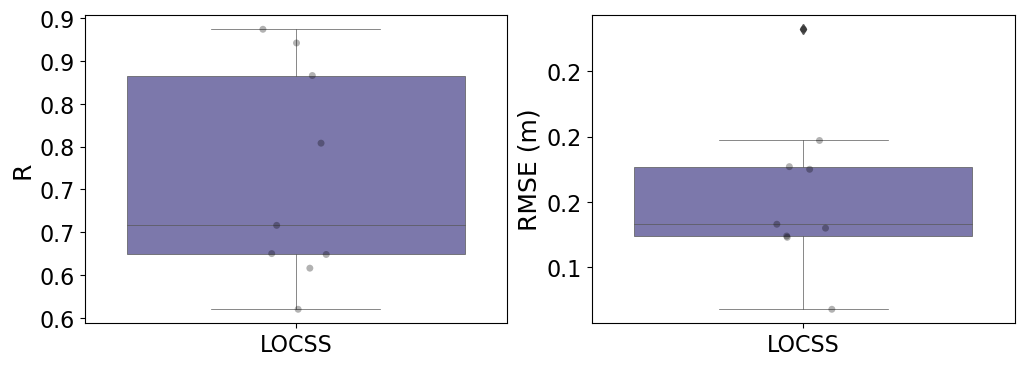

In [38]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
# sns.set_style('white')
# plt.style.use('dark_background')
plt.style.use('default')
plt.rcParams["figure.figsize"] = (12,4)
# plt.rcParams['font.family']='Arial'


# print(df.head())
# df=df_final.loc[(df_final['lake_area']<=20)|(df_final['source']=='RVBR')].copy()#.sort_values(by=['sat']).copy()
df=df_final.loc[df_final['lake_area']<=20].copy()#.sort_values(by=['sat']).copy()

df.loc[df['lake_area']<=20, 'labels']='Area <=20 km2'
# df.loc[df['source']=='RVBR', 'labels']='Reservoirs'
# df.loc[df['source']=='LOCSS', 'labels']='LOCSS'
# df.loc[df['source'].isin(['ARHN','USGS']), 'labels']='National Dataset'
df=df.sort_values(by='labels')
# df=df.loc[df['variable'].isin(['RMSE','lakearea'])]
fig, axes = plt.subplots(1,2)
x_fd='labels'
# y_fd='RHO'
# y_label=['$\\rho$', 'RMSE (m)']
y_fd='R'
y_label=['R', 'RMSE (m)']

hue='labels'#'method'

#     # col='variable'
#     # size="Lake_area"
# pal=sns.color_palette(["#7570b3", "#1b9e77", "#d95f02"], as_cmap=False)
pal=sns.color_palette(["#7570b3"], as_cmap=False)
# pal=sns.color_palette(["#7570b3",  "#d95f02"], as_cmap=False)
# color=["#7570b3", "#d95f02","#1b9e77"]
# color=["#7570b3", "#d95f02"]
color=["#7570b3"]
facet_kws={'sharey': True, 'sharex': False}

#     # for i in ['r2', 'RMSE']:
#     # df=df.loc[df[col]==i]


# g = sns.relplot(data=df,facet_kws=facet_kws,
#             x=x_fd, y=y_fd,#palette=pal,
#             hue=hue,# col=col,size=size,
#             row=row,# col_wrap=2,
#             kind="scatter", height=4, aspect=10/4)#,
                #join=False)#,
            #dodge=True)
    #                height=4, aspect=.7)
# Iterating through axes and names
# names=['Lake area <=20 $km^{2}$', 'Reservoirs']
names=['LOCSS']
i=0
pred=['R','RMSE']

# xlabels=df[hue].unique()
# print(xlabels)
for name, ax in zip(pred, axes.flatten()):
    # sns.boxplot(y=name, x= "a", data=df, orient='v', ax=ax)
    # if type(name)==list:
    #     d_to_plot=df.loc[df[row].isin(name)]
    # else:
    y_fd=name
    d_to_plot=df#.loc[df[row].isin([name])]
    g = sns.boxplot(data=d_to_plot,#facet_kws=facet_kws,
            y=y_fd,
            palette=pal,
            x=hue,
            ax=ax, linewidth=.5)
    # if name=='ME':
        # g.set(ylim=(-0.01, 0.01))
    # else: 
    sns.stripplot(x=hue, y=y_fd, data=d_to_plot, marker="o", alpha=0.3, color="black", ax=ax)
    ax.set_ylabel(y_label[i], fontsize=18)
    ax.set_xlabel('', fontsize=18)
    # ax.set_xlabel(names[i], fontsize=14)
    ax.set_yticklabels(ax.get_yticks(), size = 16)
    ax.set_xticklabels(names, size = 16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    i=i+1
fig2=plt.gcf()
plt.show()

## Supplemental figure of figure 2 with all the lakes divided into LOCSS, Additional lakes from National Datasets and Reservoirs


C:\Users\amgomez\AppData\Local\Temp\ipykernel_21120\3990585435.py:77: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\amgomez\AppData\Local\Temp\ipykernel_21120\3990585435.py:77: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



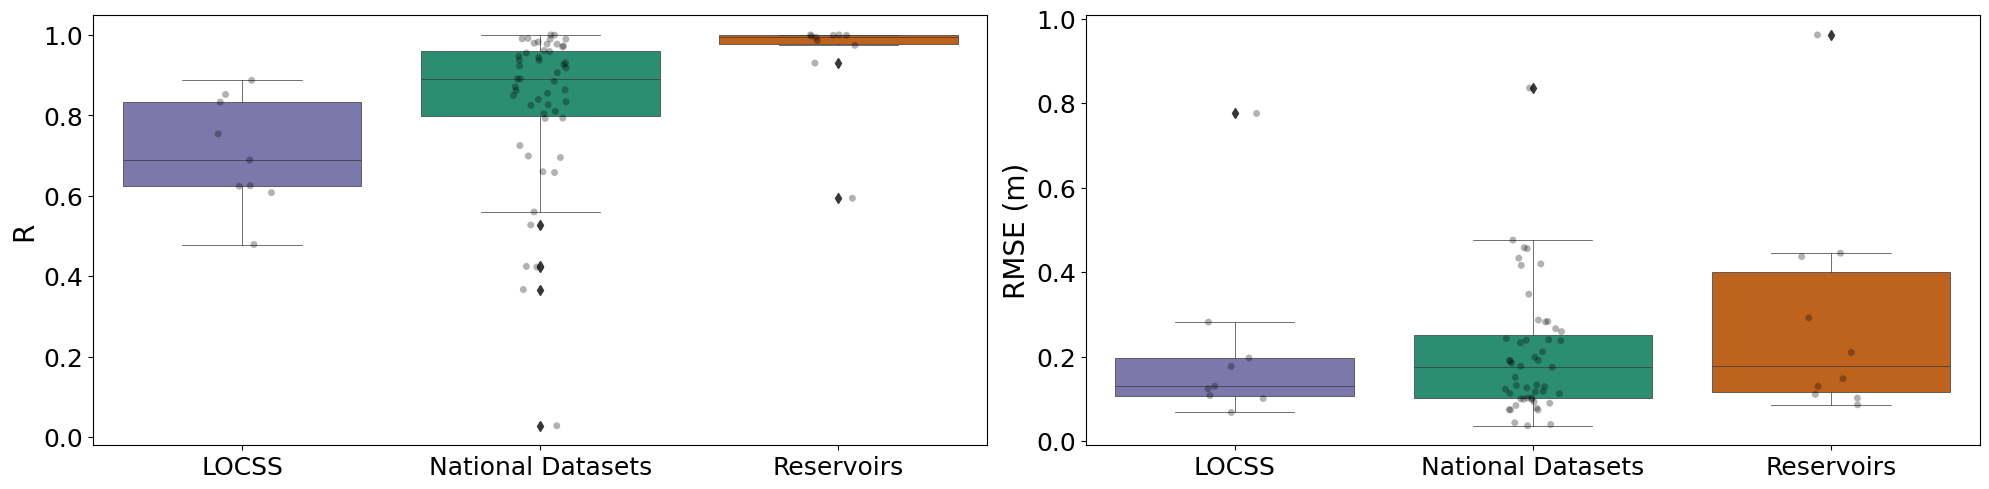

In [105]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
# sns.set_style('white')
# plt.style.use('dark_background')
plt.style.use('default')
plt.rcParams["figure.figsize"] = (20,5)
# plt.rcParams['font.family']='Arial'


# print(df.head())
df=df_final.copy()#.sort_values(by=['sat']).copy()

# df.loc[df['lake_area']<=20, 'labels']='Area <=20 km2'
# df.loc[~((df['lake_area']<=20)|(df['source']=='RVBR')), 'labels']='Other additional lakes'
df.loc[df['source']=='LOCSS', 'labels']='LOCSS'
df.loc[df['source']=='RVBR', 'labels']='Reservoirs'
df.loc[~df['source'].isin(['RVBR','LOCSS']), 'labels']='National Datasets'
# df.loc[df['source'].isin(['ARHN','USGS']), 'labels']='National Dataset'
df=df.sort_values(by='labels')
# df=df.loc[df['variable'].isin(['RMSE','lakearea'])]
fig, axes = plt.subplots(1,2)
x_fd='labels'
# y_fd='RHO'
# y_label=['$\\rho$', 'RMSE (m)']
y_fd='R'
y_label=['R', 'RMSE (m)']

hue='labels'#'method'

#     # col='variable'
#     # size="Lake_area"
pal=sns.color_palette(["#7570b3", "#1b9e77", "#d95f02"], as_cmap=False)
# pal=sns.color_palette(["#7570b3",  "#d95f02"], as_cmap=False)
color=["#7570b3", "#1b9e77","#d95f02"]
# color=["#7570b3", "#d95f02"]
facet_kws={'sharey': True, 'sharex': False}

#     # for i in ['r2', 'RMSE']:
#     # df=df.loc[df[col]==i]


# g = sns.relplot(data=df,facet_kws=facet_kws,
#             x=x_fd, y=y_fd,#palette=pal,
#             hue=hue,# col=col,size=size,
#             row=row,# col_wrap=2,
#             kind="scatter", height=4, aspect=10/4)#,
                #join=False)#,
            #dodge=True)
    #                height=4, aspect=.7)
# Iterating through axes and names
# names=['Lake area <=20 $km^{2}$','Additional lakes', 'Reservoirs']
names=['LOCSS','National Datasets','Reservoirs']
i=0
pred=['R','RMSE']

# xlabels=df[hue].unique()
# print(xlabels)
for name, ax in zip(pred, axes.flatten()):
    # sns.boxplot(y=name, x= "a", data=df, orient='v', ax=ax)
    # if type(name)==list:
    #     d_to_plot=df.loc[df[row].isin(name)]
    # else:
    y_fd=name
    d_to_plot=df#.loc[df[row].isin([name])]
    g = sns.boxplot(data=d_to_plot,#facet_kws=facet_kws,
            y=y_fd,
            palette=pal,
            x=hue,
            ax=ax, linewidth=.5)
    # if name=='ME':
        # g.set(ylim=(-0.01, 0.01))
    # else: 
    sns.stripplot(x=hue, y=y_fd, data=d_to_plot, marker="o", alpha=0.3, color="black", ax=ax)
    ax.set_ylabel(y_label[i], fontsize=20)
    ax.set_xlabel('', fontsize=20)
    # ax.set_xlabel(names[i], fontsize=14)
    ax.set_yticklabels(ax.get_yticks(), size = 18)
    ax.set_xticklabels(names, size = 18)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    i=i+1
plt.tight_layout()
fig2supl=plt.gcf()
plt.show()

In [106]:
fig2supl.savefig('../data/results/Fig_Supplemental_Results_R_RMSE_all_rho_significant.png', dpi=300)

In [31]:
df_final.loc[df_final['gauge_id']=='2234']

,gauge_id,lake_id,sat,orbit,RMSE,nRMSE,R,source,std_obs,APL,...,water_2_total_3km,no_water_pixel_3km,water_4km,outwater_to_lake_4km,water_2_total_4km,no_water_pixel_4km,water_5km,outwater_to_lake_5km,water_2_total_5km,no_water_pixel_5km
60,2234,6.610150e+09,S3A,318,0.123,73,0.658,ARHN,0.117996,0.686,...,0.000187,87.433872,0.016384,13.871792,0.000128,128.452798,0.016384,18.961603,0.000093,175.584446
61,2234,6.610150e+09,S3A,338,0.175,72,0.560,ARHN,0.113700,1.025,...,0.000187,87.433872,0.016384,13.871792,0.000128,128.452798,0.016384,18.961603,0.000093,175.584446


### Identifying the variability of RMSE with Lake Variability

In [109]:
#Only using water at 5k
predictors=['std_obs',	'APL','VE','lake_area','olength_wgs','olength_proj','TRI_median_95', 'TRI_median_all','nRMSE','n_v_obs','water_5km',
       'outwater_to_lake_5km', 'water_2_total_5km','no_water_pixel_5km']

df_melt=pd.melt(df_final, id_vars=['gauge_id','lake_id','sat','RMSE','R','source','orbit','orbit_count', 'lake_area'],  value_vars=predictors,
        var_name='predictors')
# df_melt.loc[df_melt['RMSE']!=df_melt['RMSE'].max()]#columns#['predictors'].unique()

In [44]:
# #Only for Sylvains analysis detect RMSE
# df_melt_area=df_melt.loc[(df_melt['predictors'].isin(['APL', 'std_obs']))&(~df_melt['source'].isin(['K_CA', 'K_US']))].copy()
# df_melt_area['WLVar_RMSE']=df_melt_area['value']-df_melt_area['RMSE']
# df_melt_area


# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# x_fd='value'
# y_fd='RMSE'
# facet='predictors'
# color='WLVar_RMSE'

# df=df_melt_area.loc[(df_melt_area['predictors']=='APL')]

# trace1=go.Scatter3d(x=df['value'], 
#                     y=df['source'],
#                     z=df['RMSE'],
#                    mode='markers',
#                    marker=dict(
#                         size=4,
#                         color=df['WLVar_RMSE'],                # set color to an array/list of desired values
#                         colorscale='Viridis',   # choose a colorscale
#                         opacity=0.8
#                         )
#                    )
# data=[trace1]
# layout = go.Layout(
    
#     scene = dict(
#                     xaxis = dict(
#                         title='APL (m)'),
#                     yaxis = dict(
#                         title='Data source'),
#                     zaxis = dict(
#                         title='RMSE'),),
#     margin=dict(
#         r=20, b=10, l=10, t=10
#     )
# )
# fig.update_layout(showlegend=True)
# fig = go.Figure(data=data, layout=layout)
# # fig = px.scatter(df, x=x_fd, y=y_fd, facet_col=facet,color=color,
# #                 template="simple_white")
# # fig.update_traces(marker=dict(size=5,color='#661666'))
# # fig.update_xaxes(matches=None)

# # fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.show()

## Evaluate the good of the RMSE

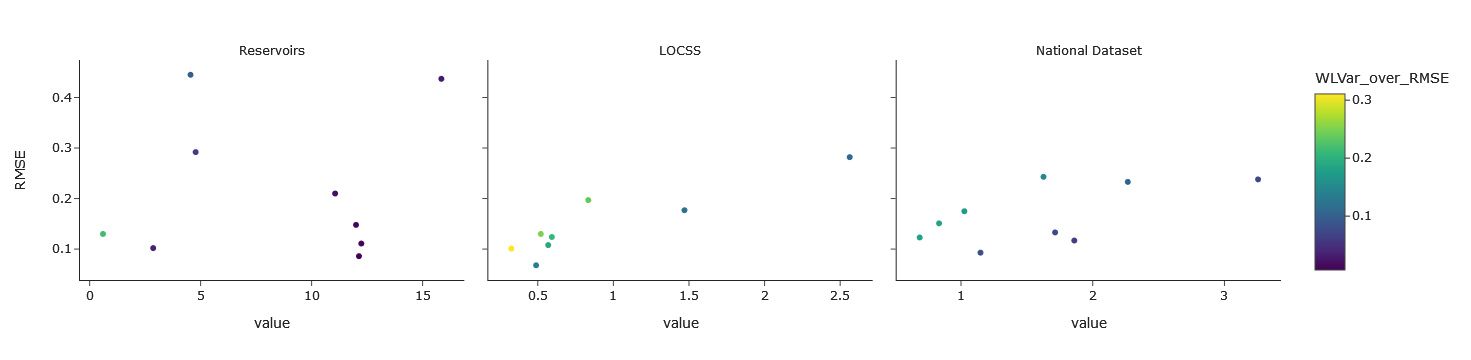

In [110]:

df_melt_area=df_melt.loc[(~df_melt['source'].isin(['K_CA', 'K_US']))&(df_melt['predictors'].isin(['APL']))].copy()
df_melt_area['WLVar_over_RMSE']=df_melt_area['RMSE']/df_melt_area['value']
df_melt_area.loc[df_melt_area['source'].isin(['ARHN','USGS']), 'labels']='National Dataset'
df_melt_area.loc[df_melt_area['source']=='LOCSS', 'labels']='LOCSS'
df_melt_area.loc[df_melt_area['source']=='RVBR', 'labels']='Reservoirs'


import plotly.express as px

df=df_melt_area
x_fd='value'
y_fd='RMSE'
facet_col='labels'#'predictors'
facet_row='labels'
color='WLVar_over_RMSE'
fig = px.scatter(df.loc[df['RMSE']<.5], x=x_fd, y=y_fd, facet_col=facet_col,color=color,#facet_row=facet_row,
                template="simple_white", width=700, height=300)
# fig.update_traces(marker=dict(size=5,color='#661666'))
fig.update_xaxes(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()
# del df_melt_area

In [66]:
df.sort_values('lake_area')

,gauge_id,lake_id,sat,RMSE,R,source,orbit,orbit_count,lake_area,predictors,value,WLVar_over_RMSE,labels
135,SLL2,1.052865e+06,S3B,0.197,0.624,LOCSS,275,1.0,0.24,APL,0.834,0.236211,LOCSS
120,HMT2,8.651200e+05,S3A,0.068,0.887,LOCSS,176,1.0,0.37,APL,0.489,0.139059,LOCSS
119,CFN2,7.320417e+09,S3A,0.130,0.608,LOCSS,18,NaN,3.72,APL,0.520,0.250000,LOCSS
118,BTN2,7.320429e+09,S3B,0.124,0.625,LOCSS,346,1.0,5.77,APL,0.593,0.209106,LOCSS
126,2234,6.610150e+09,S3A,0.175,0.560,ARHN,338,1.0,9.26,APL,1.025,0.170732,National Dataset
125,2234,6.610150e+09,S3A,0.123,0.658,ARHN,318,1.0,9.26,APL,0.686,0.179300,National Dataset
131,WEW2,7.820034e+09,S3A,0.282,0.833,LOCSS,319,1.0,9.53,APL,2.563,0.110027,LOCSS
130,2464800,7.320103e+09,S3A,0.133,0.871,USGS,97,1.0,18.05,APL,1.714,0.077596,National Dataset
129,SAW2,7.830177e+09,S3A,0.177,0.754,LOCSS,13,1.0,19.05,APL,1.470,0.120408,LOCSS
116,12036,1.203600e+04,S3B,0.437,0.999,RVBR,223,1.0,20.44,APL,15.845,0.027580,Reservoirs


In [87]:
#Amount of lakes that have RMSE/std greater than 1
df_melt_area.loc[(df_melt_area['predictors']=='std_obs')&(df_melt_area['WLVar_over_RMSE']>1)].shape
df_melt_area.loc[(df_melt_area['predictors']=='std_obs')].shape

(21, 12)

In [90]:
df_melt_area.loc[(df_melt_area['predictors']=='std_obs')&(df_melt_area['WLVar_over_RMSE']>1)
                &((df_melt_area['WLVar_over_RMSE']<1.5))].shape


(9, 12)

In [93]:
#Amount of lakes that have RMSE/std greater than 1
df_melt_area.loc[(df_melt_area['predictors']=='APL')&(df_melt_area['WLVar_over_RMSE']>1)].shape
# df_melt_area.loc[(df_melt_area['predictors']=='APL')].shape

(2, 12)

In [94]:
df_melt_area.loc[(df_melt_area['predictors']=='APL')&(df_melt_area['WLVar_over_RMSE']>1)
                &((df_melt_area['WLVar_over_RMSE']<1.5))].shape

(2, 12)

In [ ]:
df_melt_area=df_melt.loc[(df_melt['predictors'].isin(['APL', 'std_obs']))]#&(~df_melt['source'].isin(['K_CA', 'K_US']))].copy()
df_melt_area['WLVar_RMSE']=df_melt_area['value']-df_melt_area['RMSE']
df_melt_area


import plotly.express as px
df=df_melt_area
x_fd='value'
y_fd='RMSE'
facet='predictors'
color='WLVar_RMSE'
fig = px.scatter(df.loc[df['RMSE']<.5], x=x_fd, y=y_fd, facet_col=facet,color=color,
                template="simple_white")
# fig.update_traces(marker=dict(size=5,color='#661666'))
fig.update_xaxes(matches=None)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()
del df_melt_area

In [42]:
df_melt_area

,gauge_id,lake_id,sat,RMSE,R,source,orbit,orbit_count,lake_area,predictors,value,WLVar_RMSE
72,12030,1.203000e+04,J3,1.016,0.990,RVBR,44,1.0,67.04,std_obs,6.755851,5.739851
73,12030,1.203000e+04,S3A,1.854,0.969,RVBR,52,1.0,67.04,std_obs,6.534899,4.680899
74,12030,1.203000e+04,S3A,2.730,0.922,RVBR,131,1.0,67.04,std_obs,6.602417,3.872417
75,12036,1.203600e+04,J3,0.962,0.986,RVBR,82,1.0,20.44,std_obs,4.970555,4.008555
76,12036,1.203600e+04,S3B,0.437,0.999,RVBR,223,1.0,20.44,std_obs,5.961666,5.524666
...,...,...,...,...,...,...,...,...,...,...,...,...
209,SLL2,1.052865e+06,S3B,0.197,0.624,LOCSS,275,1.0,0.24,APL,0.834000,0.637000
210,6604000,7.420497e+09,S3B,0.243,0.810,USGS,240,1.0,21.27,APL,1.626000,1.383000
211,TAB2,2.200000e+01,S3A,0.776,0.852,LOCSS,97,1.0,66.10,APL,4.589000,3.813000
212,19069,1.906900e+04,S3A,0.210,0.997,RVBR,95,1.0,64.98,APL,11.057000,10.847000


/tmp/ipykernel_1994609/800550747.py:64: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_1994609/800550747.py:64: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_1994609/800550747.py:64: UserWarning:

FixedFormatter should only be used together with FixedLocator



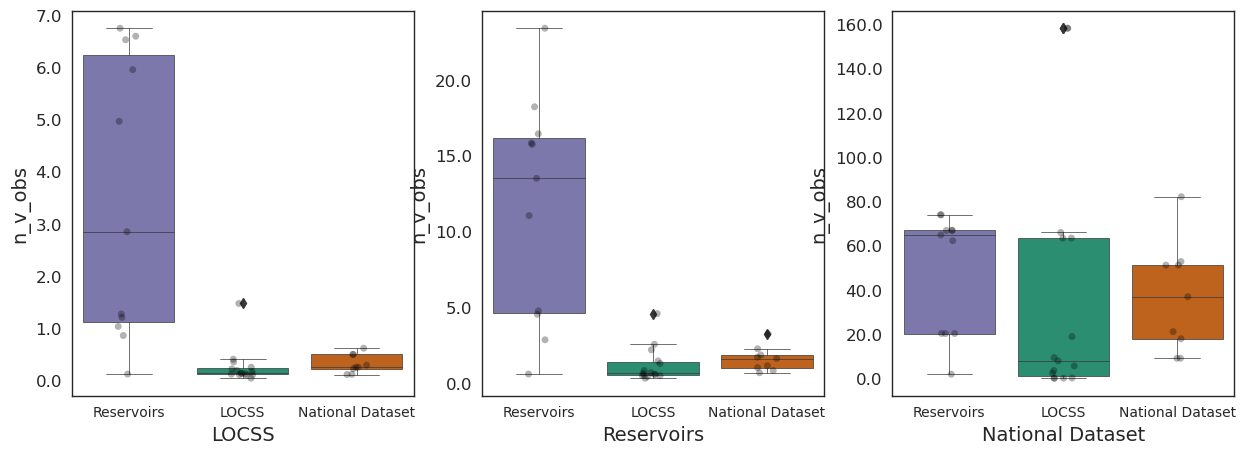

In [23]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
sns.set_style('white')
plt.rcParams["figure.figsize"] = (15,5)
# plt.rcParams['font.family']='Arial'


# print(df.head())
df=df_final.loc[df_final['source'].isin(['LOCSS', 'RVBR','ARHN','USGS'])].copy()#.sort_values(by=['sat']).copy()

df.loc[df['source']=='LOCSS', 'labels']='LOCSS'
df.loc[df['source']=='RVBR', 'labels']='Reservoirs'
df.loc[df['source'].isin(['ARHN','USGS']), 'labels']='National Dataset'

# df=df.loc[df['variable'].isin(['RMSE','lakearea'])]
fig, axes = plt.subplots(1,3)
x_fd='source'
y_fd='n_v_obs'
y_label='n_v_obs'
hue='labels'#'method'
#     # col='variable'
#     # size="Lake_area"
pal=sns.color_palette(["#7570b3", "#1b9e77", "#d95f02"], as_cmap=False)
color=["#7570b3", "#d95f02","#1b9e77"]
facet_kws={'sharey': True, 'sharex': False}
row='source'
#     # for i in ['r2', 'RMSE']:
#     # df=df.loc[df[col]==i]


# g = sns.relplot(data=df,facet_kws=facet_kws,
#             x=x_fd, y=y_fd,#palette=pal,
#             hue=hue,# col=col,size=size,
#             row=row,# col_wrap=2,
#             kind="scatter", height=4, aspect=10/4)#,
                #join=False)#,
            #dodge=True)
    #                height=4, aspect=.7)
# Iterating through axes and names
names=['LOCSS', 'Reservoirs','National Dataset']
i=0
pred=['std_obs','APL','lake_area','olength_wgs','TRI_median_all','nRMSE','n_v_obs','water_2_total_5km']
# datasets=['LOCSS', 'RVBR',['ARHN','USGS']]
# xlabels=df[hue].unique()
# print(xlabels)
for name, ax in zip(pred, axes.flatten()):
    # sns.boxplot(y=name, x= "a", data=df, orient='v', ax=ax)
    # if type(name)==list:
    #     d_to_plot=df.loc[df[row].isin(name)]
    # else:
    y_fd=name
    d_to_plot=df#.loc[df[row].isin([name])]
    g = sns.boxplot(data=d_to_plot,#facet_kws=facet_kws,
            y=y_fd,palette=pal,
            x=hue,
            ax=ax, linewidth=.5)
    # if name=='ME':
        # g.set(ylim=(-0.01, 0.01))
    # else: 
    sns.stripplot(x=hue, y=y_fd, data=d_to_plot, marker="o", alpha=0.3, color="black", ax=ax)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('', fontsize=14)
    ax.set_xlabel(names[i], fontsize=14)
    ax.set_yticklabels(ax.get_yticks(), size = 12)
    # ax.set_xticklabels(xlabels, size = 14)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    i=i+1
    

In [107]:
df_final.to_csv('../data/results/order_importance_02_22_24.csv', sep=',')